In [1]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange

olefile module not found


In [2]:
# need to change
ipts="25265"

In [3]:
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
os.listdir(ct_loc)

['2022_11_08_tube1_sample1_2_3_from_bottom',
 '2022_11_09_tube2_sample5_4_6_from_bottom']

In [4]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2022_11_09']

In [5]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
os.listdir(dc_loc)

['2022_11_08_QHY']

In [8]:
###################### need to change start
sample_name = "2022_11_09_tube2_sample5_4_6_from_bottom"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_11_09")
dc_dir = os.path.join(dc_loc, "2022_11_08_QHY")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/norm_to_recon/" + sample_name
ob_name = save_to + "/" + 'ob_0000'
dc_name = save_to + "/" + 'dc_0000'
###################### need to change end

# Find ROI and crop

In [9]:
ct_file_list = os.listdir(ct_dir)
# ct_file_list.remove('20221108_dummy_0005_000_000_0044.tiff')
fname_df = rocku.get_fname_df(ct_file_list, golden_ratio=True)
fname_df.sort_values('ang_deg', inplace=True)
ang_list = fname_df['ang_deg'].to_list()
ordered_list = fname_df['fname'].to_list()
fname_df

,fname,ang_deg,ang_rad,idx
48,20221109_image_000_000_0030_3021.tiff,0.000,0.000000,3021
1460,20221109_image_000_000_0030_3019.tiff,0.000,0.000000,3019
411,20221109_image_000_000_0030_3022.tiff,0.000,0.000000,3022
1440,20221109_image_000_000_0030_3026.tiff,0.000,0.000000,3026
523,20221109_image_000_000_0030_3020.tiff,0.000,0.000000,3020
...,...,...,...,...
1573,20221111_image_358_088_0030_5632.tiff,358.088,6.249815,5632
279,20221111_image_358_088_0030_5636.tiff,358.088,6.249815,5636
207,20221111_image_358_088_0030_5635.tiff,358.088,6.249815,5635
456,20221111_image_358_088_0030_5634.tiff,358.088,6.249815,5634


2it [00:02,  1.02s/it]


Projection at 0 degree:


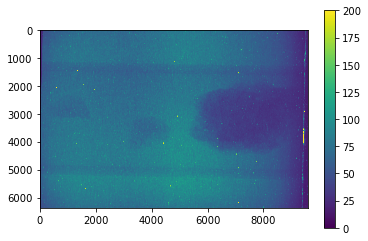

Projection at 180 degree:


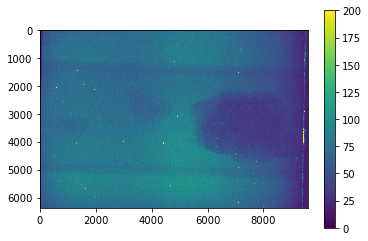

In [10]:
proj180_idx, proj180_ang = rocku.find_idx_by_ang(ang_list, 180)
proj000_idx, proj000_ang = rocku.find_idx_by_ang(ang_list, 0)
preview_image_stack = rocku.read_tiff_stack(ct_dir, [ordered_list[proj000_idx], ordered_list[proj180_idx]])
print("Projection at 0 degree:")
plt.imshow(preview_image_stack[0], vmin=0, vmax=200)
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(preview_image_stack[1], vmin=0, vmax=200)
plt.colorbar()
plt.show()

In [11]:
preview_image_stack.shape

(2, 6388, 9576)

Projection at 0 degree:


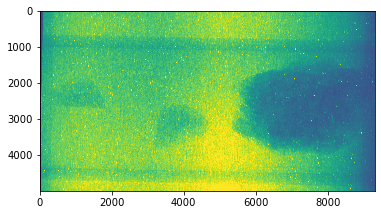

Projection at 180 degree:


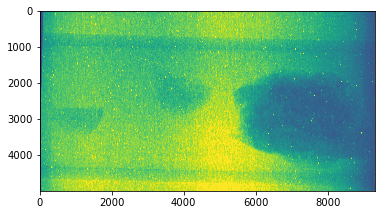

In [12]:
###################### need to change start
crop = True
crop_left = 0
crop_right = 9300
crop_top = 500
crop_bottom = 5500
###################### need to change end
preview_image_stack_crop = rocku.crop(preview_image_stack, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Projection at 0 degree:")
plt.imshow(preview_image_stack_crop[0], vmin=0, vmax=100)
plt.show()
print("Projection at 180 degree:")
plt.imshow(preview_image_stack_crop[1], vmin=0, vmax=100)
plt.show()

# Preprocess OB

Loading OB ...


27it [00:06,  4.43it/s]


(27, 6388, 9576)
Cropping ...
Removing outliers ...
Combining with median ...
(5000, 9300)
Rotating by 90 deg ...
(9300, 5000)


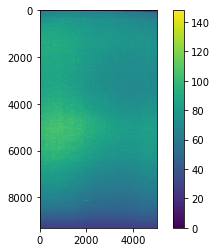

In [13]:
print('Loading OB ...')
ob_stack = rocku.read_tiff_stack(ob_dir, os.listdir(ob_dir))
print(ob_stack.shape)
print('Cropping ...')
ob_stack_crop = rocku.crop(ob_stack, crop_left, crop_right, crop_top, crop_bottom, crop)
print('Removing outliers ...')
ob_stack_cleaned = tomopy.remove_outlier(ob_stack_crop, gamma_diff)
print('Combining with median ...')
if ob_stack_cleaned.shape[0] == 1:
    ob_med = ob_stack_cleaned[:]
else:
    ob_med = np.median(ob_stack_cleaned, axis=0).astype(np.ushort)
print(ob_med.shape)
print('Rotating by 90 deg ...')
ob_rot = np.rot90(ob_med, k=-1)
print(ob_rot.shape)
plt.imshow(ob_rot)
plt.colorbar()
plt.show()
# print('Saving {} ...'.format(ob_name))
# dxchange.write_tiff(ob_rot, fname=ob_name, overwrite=True)

# Preprocess DC

Loading DC ...


30it [00:06,  4.68it/s]


(30, 6388, 9576)
Cropping ...
Removing outliers ...
Combining with median ...
(5000, 9300)
Rotating by 90 deg ...
(9300, 5000)


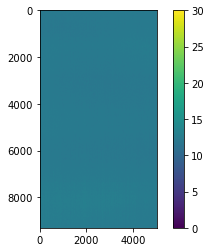

In [14]:
print('Loading DC ...')
dc_stack = rocku.read_tiff_stack(dc_dir, os.listdir(dc_dir))
print(dc_stack.shape)
print('Cropping ...')
dc_stack_crop = rocku.crop(dc_stack, crop_left, crop_right, crop_top, crop_bottom, crop)
print('Removing outliers ...')
dc_stack_cleaned = tomopy.remove_outlier(dc_stack_crop, gamma_diff)
print('Combining with median ...')
if dc_stack_cleaned.shape[0] == 1:
    dc_med = dc_stack_cleaned[:]
else:
    dc_med = np.median(dc_stack_cleaned, axis=0).astype(np.ushort)
print(dc_med.shape)
print('Rotating by 90 deg ...')
dc_rot = np.rot90(dc_med, k=-1)
print(dc_rot.shape)
plt.imshow(dc_rot)
plt.colorbar()
plt.show()
# print('Saving {} ...'.format(dc_name))
# dxchange.write_tiff(dc_rot, fname=dc_name, overwrite=True)

# Preprocess CT scan files

In [15]:
grouped_dict = {}
for i, e_ang in enumerate(set(ang_list)):
    _fname_list = list(fname_df[fname_df['ang_deg'] == e_ang]['fname'])
    grouped_dict[_fname_list[0]] = _fname_list
pprint.pprint(grouped_dict)

{'20221109_image_000_000_0030_3021.tiff': ['20221109_image_000_000_0030_3021.tiff',
                                           '20221109_image_000_000_0030_3019.tiff',
                                           '20221109_image_000_000_0030_3022.tiff',
                                           '20221109_image_000_000_0030_3026.tiff',
                                           '20221109_image_000_000_0030_3020.tiff',
                                           '20221109_image_000_000_0030_3025.tiff',
                                           '20221109_image_000_000_0030_3023.tiff',
                                           '20221109_image_000_000_0030_3024.tiff'],
 '20221110_image_000_090_0030_3842.tiff': ['20221110_image_000_090_0030_3842.tiff',
                                           '20221110_image_000_090_0030_3841.tiff',
                                           '20221110_image_000_090_0030_3839.tiff',
                                           '20221110_image_000_090_0030_384

                                           '20221110_image_275_092_0030_3808.tiff',
                                           '20221110_image_275_092_0030_3804.tiff',
                                           '20221110_image_275_092_0030_3802.tiff',
                                           '20221110_image_275_092_0030_3806.tiff',
                                           '20221110_image_275_092_0030_3803.tiff',
                                           '20221110_image_275_092_0030_3807.tiff'],
 '20221110_image_276_082_0030_4605.tiff': ['20221110_image_276_082_0030_4605.tiff',
                                           '20221110_image_276_082_0030_4609.tiff',
                                           '20221110_image_276_082_0030_4610.tiff',
                                           '20221110_image_276_082_0030_4604.tiff',
                                           '20221110_image_276_082_0030_4603.tiff',
                                           '20221110_image_276_082_0030_460

In [16]:
# for e_group in ['20221108_Image_180_000_0030_0063.tiff']:
for e_group in grouped_dict.keys():
    _fname_list = grouped_dict[e_group]
    print('##################################')
    print('Processing group start with {} ...'.format(e_group))
    print('Loading ...')
    _image_stack = rocku.read_tiff_stack(ct_dir, _fname_list)
    print('Cropping ...')
    _image_stack_crop = rocku.crop(_image_stack, crop_left, crop_right, crop_top, crop_bottom, crop)
    print('Removing outliers ...')
    _image_stack_cleaned = tomopy.remove_outlier(_image_stack_crop, gamma_diff)
    print('Combining with median ...')
    _image_med = np.median(_image_stack_cleaned, axis=0).astype(np.ushort)
    print('Rotating by 90 deg ...')
    _image_rot = np.rot90(_image_med, k=-1)
    _image_norm, _ob, _dc = rocku.normalize(_image_rot, ob_rot, dc_rot)
    fname = save_to + "/" + e_group
    print('Saving {} ...'.format(fname))
    dxchange.write_tiff(_image_norm, fname=fname, overwrite=True)

##################################
Processing group start with 20221109_image_000_000_0030_3021.tiff ...
Loading ...


8it [00:01,  4.53it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221109_image_000_000_0030_3021.tiff ...


/SNS/users/y9z/Documents/scripts/utilities.py:293: RuntimeWarning: divide by zero encountered in divide
  proj_norm = np.true_divide(_proj, _ob, dtype=np.float32)
/SNS/users/y9z/Documents/scripts/utilities.py:293: RuntimeWarning: invalid value encountered in divide
  proj_norm = np.true_divide(_proj, _ob, dtype=np.float32)


##################################
Processing group start with 20221110_image_004_074_0030_3649.tiff ...
Loading ...


9it [00:02,  4.44it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_004_074_0030_3649.tiff ...
##################################
Processing group start with 20221110_image_005_064_0030_4456.tiff ...
Loading ...


9it [00:01,  5.23it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_005_064_0030_4456.tiff ...
##################################
Processing group start with 20221110_image_006_055_0030_5256.tiff ...
Loading ...


9it [00:02,  4.42it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_006_055_0030_5256.tiff ...
##################################
Processing group start with 20221111_image_007_045_0030_6052.tiff ...
Loading ...


9it [00:02,  3.88it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_007_045_0030_6052.tiff ...
##################################
Processing group start with 20221110_image_008_057_0030_3463.tiff ...
Loading ...


9it [00:02,  3.94it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_008_057_0030_3463.tiff ...
##################################
Processing group start with 20221110_image_009_047_0030_4263.tiff ...
Loading ...


9it [00:02,  4.45it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_009_047_0030_4263.tiff ...
##################################
Processing group start with 20221110_image_010_038_0030_5069.tiff ...
Loading ...


9it [00:01,  4.82it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_010_038_0030_5069.tiff ...
##################################
Processing group start with 20221111_image_011_028_0030_5868.tiff ...
Loading ...


9it [00:02,  3.46it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_011_028_0030_5868.tiff ...
##################################
Processing group start with 20221110_image_012_040_0030_3272.tiff ...
Loading ...


9it [00:02,  3.62it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_012_040_0030_3272.tiff ...
##################################
Processing group start with 20221110_image_013_030_0030_4072.tiff ...
Loading ...


9it [00:02,  4.34it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_013_030_0030_4072.tiff ...
##################################
Processing group start with 20221110_image_014_021_0030_4873.tiff ...
Loading ...


9it [00:03,  2.94it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_014_021_0030_4873.tiff ...
##################################
Processing group start with 20221111_image_015_011_0030_5681.tiff ...
Loading ...


9it [00:02,  4.34it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_015_011_0030_5681.tiff ...
##################################
Processing group start with 20221110_image_016_023_0030_3088.tiff ...
Loading ...


9it [00:02,  3.63it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_016_023_0030_3088.tiff ...
##################################
Processing group start with 20221110_image_017_014_0030_3886.tiff ...
Loading ...


9it [00:02,  3.95it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_017_014_0030_3886.tiff ...
##################################
Processing group start with 20221110_image_018_004_0030_4685.tiff ...
Loading ...


9it [00:03,  2.90it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_018_004_0030_4685.tiff ...
##################################
Processing group start with 20221111_image_018_094_0030_5487.tiff ...
Loading ...


9it [00:02,  3.87it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_018_094_0030_5487.tiff ...
##################################
Processing group start with 20221110_image_020_097_0030_3697.tiff ...
Loading ...


9it [00:02,  4.45it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_020_097_0030_3697.tiff ...
##################################
Processing group start with 20221110_image_021_087_0030_4497.tiff ...
Loading ...


9it [00:04,  1.97it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_021_087_0030_4497.tiff ...
##################################
Processing group start with 20221110_image_022_078_0030_5302.tiff ...
Loading ...


9it [00:02,  3.65it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_022_078_0030_5302.tiff ...
##################################
Processing group start with 20221111_image_023_068_0030_6097.tiff ...
Loading ...


9it [00:02,  3.61it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_023_068_0030_6097.tiff ...
##################################
Processing group start with 20221110_image_024_080_0030_3506.tiff ...
Loading ...


9it [00:02,  3.85it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_024_080_0030_3506.tiff ...
##################################
Processing group start with 20221110_image_025_070_0030_4306.tiff ...
Loading ...


9it [00:02,  3.53it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_025_070_0030_4306.tiff ...
##################################
Processing group start with 20221110_image_026_061_0030_5113.tiff ...
Loading ...


9it [00:02,  3.48it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_026_061_0030_5113.tiff ...
##################################
Processing group start with 20221111_image_027_051_0030_5911.tiff ...
Loading ...


9it [00:02,  3.58it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_027_051_0030_5911.tiff ...
##################################
Processing group start with 20221110_image_028_063_0030_3323.tiff ...
Loading ...


9it [00:02,  4.30it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_028_063_0030_3323.tiff ...
##################################
Processing group start with 20221110_image_029_053_0030_4121.tiff ...
Loading ...


9it [00:02,  3.67it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_029_053_0030_4121.tiff ...
##################################
Processing group start with 20221110_image_030_044_0030_4923.tiff ...
Loading ...


9it [00:02,  3.30it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_030_044_0030_4923.tiff ...
##################################
Processing group start with 20221111_image_031_034_0030_5719.tiff ...
Loading ...


9it [00:03,  2.36it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_031_034_0030_5719.tiff ...
##################################
Processing group start with 20221110_image_032_046_0030_3133.tiff ...
Loading ...


9it [00:02,  3.67it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_032_046_0030_3133.tiff ...
##################################
Processing group start with 20221110_image_033_037_0030_3931.tiff ...
Loading ...


9it [00:02,  3.41it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_033_037_0030_3931.tiff ...
##################################
Processing group start with 20221110_image_034_027_0030_4731.tiff ...
Loading ...


9it [00:02,  4.07it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_034_027_0030_4731.tiff ...
##################################
Processing group start with 20221111_image_035_017_0030_5535.tiff ...
Loading ...


9it [00:02,  3.09it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_035_017_0030_5535.tiff ...
##################################
Processing group start with 20221110_image_037_020_0030_3738.tiff ...
Loading ...


9it [00:02,  4.18it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_037_020_0030_3738.tiff ...
##################################
Processing group start with 20221110_image_038_010_0030_4540.tiff ...
Loading ...


9it [00:02,  3.95it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_038_010_0030_4540.tiff ...
##################################
Processing group start with 20221110_image_039_001_0030_5348.tiff ...
Loading ...


9it [00:02,  3.56it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_039_001_0030_5348.tiff ...
##################################
Processing group start with 20221111_image_039_091_0030_6143.tiff ...
Loading ...


9it [00:02,  3.59it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_039_091_0030_6143.tiff ...
##################################
Processing group start with 20221110_image_041_003_0030_3552.tiff ...
Loading ...


9it [00:02,  3.91it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_041_003_0030_3552.tiff ...
##################################
Processing group start with 20221110_image_041_093_0030_4356.tiff ...
Loading ...


9it [00:02,  4.11it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_041_093_0030_4356.tiff ...
##################################
Processing group start with 20221110_image_042_084_0030_5154.tiff ...
Loading ...


9it [00:02,  3.81it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_042_084_0030_5154.tiff ...
##################################
Processing group start with 20221111_image_043_074_0030_5956.tiff ...
Loading ...


9it [00:02,  3.26it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_043_074_0030_5956.tiff ...
##################################
Processing group start with 20221110_image_044_086_0030_3365.tiff ...
Loading ...


9it [00:02,  3.47it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_044_086_0030_3365.tiff ...
##################################
Processing group start with 20221110_image_045_076_0030_4162.tiff ...
Loading ...


9it [00:02,  4.24it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_045_076_0030_4162.tiff ...
##################################
Processing group start with 20221110_image_046_067_0030_4964.tiff ...
Loading ...


9it [00:02,  3.95it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_046_067_0030_4964.tiff ...
##################################
Processing group start with 20221111_image_047_057_0030_5764.tiff ...
Loading ...


9it [00:02,  3.57it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_047_057_0030_5764.tiff ...
##################################
Processing group start with 20221110_image_048_069_0030_3177.tiff ...
Loading ...


9it [00:02,  4.45it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_048_069_0030_3177.tiff ...
##################################
Processing group start with 20221110_image_049_060_0030_3974.tiff ...
Loading ...


9it [00:02,  4.05it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_049_060_0030_3974.tiff ...
##################################
Processing group start with 20221110_image_050_050_0030_4781.tiff ...
Loading ...


9it [00:02,  3.91it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_050_050_0030_4781.tiff ...
##################################
Processing group start with 20221111_image_051_041_0030_5582.tiff ...
Loading ...


9it [00:02,  3.58it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_051_041_0030_5582.tiff ...
##################################
Processing group start with 20221110_image_053_043_0030_3787.tiff ...
Loading ...


9it [00:02,  3.80it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_053_043_0030_3787.tiff ...
##################################
Processing group start with 20221110_image_054_033_0030_4588.tiff ...
Loading ...


9it [00:01,  4.70it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_054_033_0030_4588.tiff ...
##################################
Processing group start with 20221111_image_055_024_0030_5389.tiff ...
Loading ...


9it [00:02,  3.94it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_055_024_0030_5389.tiff ...
##################################
Processing group start with 20221110_image_057_026_0030_3600.tiff ...
Loading ...


9it [00:02,  3.48it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_057_026_0030_3600.tiff ...
##################################
Processing group start with 20221110_image_058_016_0030_4396.tiff ...
Loading ...


9it [00:02,  3.87it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_058_016_0030_4396.tiff ...
##################################
Processing group start with 20221110_image_059_007_0030_5198.tiff ...
Loading ...


9it [00:02,  3.99it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_059_007_0030_5198.tiff ...
##################################
Processing group start with 20221111_image_059_097_0030_6003.tiff ...
Loading ...


9it [00:02,  4.34it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_059_097_0030_6003.tiff ...
##################################
Processing group start with 20221110_image_061_009_0030_3413.tiff ...
Loading ...


9it [00:02,  3.02it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_061_009_0030_3413.tiff ...
##################################
Processing group start with 20221110_image_062_000_0030_4208.tiff ...
Loading ...


9it [00:02,  3.06it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_062_000_0030_4208.tiff ...
##################################
Processing group start with 20221110_image_062_090_0030_5015.tiff ...
Loading ...


9it [00:02,  3.20it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_062_090_0030_5015.tiff ...
##################################
Processing group start with 20221111_image_063_080_0030_5813.tiff ...
Loading ...


9it [00:02,  3.76it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_063_080_0030_5813.tiff ...
##################################
Processing group start with 20221110_image_064_092_0030_3216.tiff ...
Loading ...


9it [00:02,  3.89it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_064_092_0030_3216.tiff ...
##################################
Processing group start with 20221110_image_065_083_0030_4017.tiff ...
Loading ...


9it [00:02,  3.72it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_065_083_0030_4017.tiff ...
##################################
Processing group start with 20221110_image_066_073_0030_4818.tiff ...
Loading ...


9it [00:02,  4.23it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_066_073_0030_4818.tiff ...
##################################
Processing group start with 20221111_image_067_064_0030_5624.tiff ...
Loading ...


9it [00:02,  3.31it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_067_064_0030_5624.tiff ...
##################################
Processing group start with 20221110_image_069_066_0030_3830.tiff ...
Loading ...


9it [00:02,  3.38it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_069_066_0030_3830.tiff ...
##################################
Processing group start with 20221110_image_070_056_0030_4635.tiff ...
Loading ...


9it [00:02,  4.31it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_070_056_0030_4635.tiff ...
##################################
Processing group start with 20221111_image_071_047_0030_5432.tiff ...
Loading ...


9it [00:02,  4.22it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_071_047_0030_5432.tiff ...
##################################
Processing group start with 20221110_image_073_049_0030_3647.tiff ...
Loading ...


9it [00:02,  3.73it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_073_049_0030_3647.tiff ...
##################################
Processing group start with 20221110_image_074_039_0030_4446.tiff ...
Loading ...


9it [00:02,  3.65it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_074_039_0030_4446.tiff ...
##################################
Processing group start with 20221110_image_075_030_0030_5245.tiff ...
Loading ...


9it [00:02,  3.31it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_075_030_0030_5245.tiff ...
##################################
Processing group start with 20221111_image_076_020_0030_6050.tiff ...
Loading ...


9it [00:02,  3.68it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_076_020_0030_6050.tiff ...
##################################
Processing group start with 20221110_image_077_032_0030_3458.tiff ...
Loading ...


9it [00:02,  4.08it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_077_032_0030_3458.tiff ...
##################################
Processing group start with 20221110_image_078_023_0030_4251.tiff ...
Loading ...


9it [00:02,  3.33it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_078_023_0030_4251.tiff ...
##################################
Processing group start with 20221110_image_079_013_0030_5055.tiff ...
Loading ...


9it [00:02,  3.77it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_079_013_0030_5055.tiff ...
##################################
Processing group start with 20221111_image_080_003_0030_5853.tiff ...
Loading ...


9it [00:02,  3.50it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_080_003_0030_5853.tiff ...
##################################
Processing group start with 20221110_image_081_015_0030_3261.tiff ...
Loading ...


9it [00:02,  3.66it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_081_015_0030_3261.tiff ...
##################################
Processing group start with 20221110_image_082_006_0030_4062.tiff ...
Loading ...


9it [00:03,  2.85it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_082_006_0030_4062.tiff ...
##################################
Processing group start with 20221110_image_082_096_0030_4864.tiff ...
Loading ...


9it [00:02,  4.01it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_082_096_0030_4864.tiff ...
##################################
Processing group start with 20221111_image_083_087_0030_5667.tiff ...
Loading ...


9it [00:02,  3.80it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_083_087_0030_5667.tiff ...
##################################
Processing group start with 20221110_image_084_098_0030_3073.tiff ...
Loading ...


9it [00:02,  3.91it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_084_098_0030_3073.tiff ...
##################################
Processing group start with 20221110_image_085_089_0030_3878.tiff ...
Loading ...


9it [00:02,  3.16it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_085_089_0030_3878.tiff ...
##################################
Processing group start with 20221110_image_086_079_0030_4675.tiff ...
Loading ...


9it [00:01,  4.51it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_086_079_0030_4675.tiff ...
##################################
Processing group start with 20221111_image_087_070_0030_5481.tiff ...
Loading ...


9it [00:02,  3.40it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_087_070_0030_5481.tiff ...
##################################
Processing group start with 20221110_image_089_072_0030_3687.tiff ...
Loading ...


9it [00:02,  4.15it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_089_072_0030_3687.tiff ...
##################################
Processing group start with 20221110_image_090_000_0030_3034.tiff ...
Loading ...


9it [00:02,  4.29it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_090_000_0030_3034.tiff ...
##################################
Processing group start with 20221110_image_090_062_0030_4491.tiff ...
Loading ...


9it [00:02,  4.32it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_090_062_0030_4491.tiff ...
##################################
Processing group start with 20221110_image_091_053_0030_5290.tiff ...
Loading ...


9it [00:02,  3.27it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_091_053_0030_5290.tiff ...
##################################
Processing group start with 20221111_image_092_043_0030_6089.tiff ...
Loading ...


9it [00:02,  3.69it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_092_043_0030_6089.tiff ...
##################################
Processing group start with 20221110_image_093_055_0030_3503.tiff ...
Loading ...


9it [00:02,  3.48it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_093_055_0030_3503.tiff ...
##################################
Processing group start with 20221110_image_094_046_0030_4297.tiff ...
Loading ...


9it [00:02,  3.67it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_094_046_0030_4297.tiff ...
##################################
Processing group start with 20221110_image_095_036_0030_5099.tiff ...
Loading ...


9it [00:02,  3.96it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_095_036_0030_5099.tiff ...
##################################
Processing group start with 20221111_image_096_027_0030_5899.tiff ...
Loading ...


9it [00:02,  3.83it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_096_027_0030_5899.tiff ...
##################################
Processing group start with 20221110_image_097_038_0030_3313.tiff ...
Loading ...


9it [00:03,  2.96it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_097_038_0030_3313.tiff ...
##################################
Processing group start with 20221110_image_098_029_0030_4107.tiff ...
Loading ...


9it [00:02,  3.81it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_098_029_0030_4107.tiff ...
##################################
Processing group start with 20221110_image_099_019_0030_4911.tiff ...
Loading ...


9it [00:02,  4.47it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_099_019_0030_4911.tiff ...
##################################
Processing group start with 20221111_image_100_010_0030_5717.tiff ...
Loading ...


9it [00:02,  3.72it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_100_010_0030_5717.tiff ...
##################################
Processing group start with 20221110_image_101_022_0030_3121.tiff ...
Loading ...


9it [00:02,  3.51it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_101_022_0030_3121.tiff ...
##################################
Processing group start with 20221110_image_102_012_0030_3921.tiff ...
Loading ...


9it [00:02,  4.28it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_102_012_0030_3921.tiff ...
##################################
Processing group start with 20221110_image_103_002_0030_4725.tiff ...
Loading ...


9it [00:02,  3.54it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_103_002_0030_4725.tiff ...
##################################
Processing group start with 20221111_image_103_093_0030_5522.tiff ...
Loading ...


9it [00:02,  4.10it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_103_093_0030_5522.tiff ...
##################################
Processing group start with 20221110_image_105_095_0030_3736.tiff ...
Loading ...


9it [00:02,  3.72it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_105_095_0030_3736.tiff ...
##################################
Processing group start with 20221110_image_106_086_0030_4535.tiff ...
Loading ...


9it [00:02,  3.44it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_106_086_0030_4535.tiff ...
##################################
Processing group start with 20221110_image_107_076_0030_5335.tiff ...
Loading ...


9it [00:02,  3.77it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_107_076_0030_5335.tiff ...
##################################
Processing group start with 20221111_image_108_066_0030_6138.tiff ...
Loading ...


9it [00:02,  3.19it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_108_066_0030_6138.tiff ...
##################################
Processing group start with 20221110_image_109_078_0030_3541.tiff ...
Loading ...


9it [00:02,  4.02it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_109_078_0030_3541.tiff ...
##################################
Processing group start with 20221110_image_110_069_0030_4342.tiff ...
Loading ...


9it [00:02,  3.90it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_110_069_0030_4342.tiff ...
##################################
Processing group start with 20221110_image_111_059_0030_5147.tiff ...
Loading ...


9it [00:02,  4.22it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_111_059_0030_5147.tiff ...
##################################
Processing group start with 20221111_image_112_050_0030_5948.tiff ...
Loading ...


9it [00:02,  3.19it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_112_050_0030_5948.tiff ...
##################################
Processing group start with 20221110_image_113_061_0030_3355.tiff ...
Loading ...


9it [00:02,  3.87it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_113_061_0030_3355.tiff ...
##################################
Processing group start with 20221110_image_114_052_0030_4156.tiff ...
Loading ...


9it [00:03,  2.59it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_114_052_0030_4156.tiff ...
##################################
Processing group start with 20221110_image_115_042_0030_4957.tiff ...
Loading ...


9it [00:02,  3.62it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_115_042_0030_4957.tiff ...
##################################
Processing group start with 20221111_image_116_033_0030_5762.tiff ...
Loading ...


9it [00:02,  3.09it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_116_033_0030_5762.tiff ...
##################################
Processing group start with 20221110_image_117_045_0030_3162.tiff ...
Loading ...


9it [00:02,  3.26it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_117_045_0030_3162.tiff ...
##################################
Processing group start with 20221110_image_118_035_0030_3970.tiff ...
Loading ...


9it [00:02,  3.31it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_118_035_0030_3970.tiff ...
##################################
Processing group start with 20221110_image_119_025_0030_4764.tiff ...
Loading ...


9it [00:02,  3.22it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_119_025_0030_4764.tiff ...
##################################
Processing group start with 20221111_image_120_016_0030_5566.tiff ...
Loading ...


9it [00:03,  2.78it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_120_016_0030_5566.tiff ...
##################################
Processing group start with 20221110_image_122_018_0030_3777.tiff ...
Loading ...


9it [00:02,  3.40it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_122_018_0030_3777.tiff ...
##################################
Processing group start with 20221110_image_123_009_0030_4579.tiff ...
Loading ...


9it [00:02,  3.35it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_123_009_0030_4579.tiff ...
##################################
Processing group start with 20221111_image_123_099_0030_5384.tiff ...
Loading ...


8it [00:03,  2.50it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_123_099_0030_5384.tiff ...
##################################
Processing group start with 20221110_image_126_001_0030_3592.tiff ...
Loading ...


9it [00:02,  3.39it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_126_001_0030_3592.tiff ...
##################################
Processing group start with 20221110_image_126_092_0030_4393.tiff ...
Loading ...


9it [00:02,  3.30it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_126_092_0030_4393.tiff ...
##################################
Processing group start with 20221110_image_127_082_0030_5190.tiff ...
Loading ...


9it [00:02,  3.83it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_127_082_0030_5190.tiff ...
##################################
Processing group start with 20221111_image_128_073_0030_5989.tiff ...
Loading ...


9it [00:03,  2.98it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_128_073_0030_5989.tiff ...
##################################
Processing group start with 20221110_image_129_084_0030_3401.tiff ...
Loading ...


9it [00:02,  3.65it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_129_084_0030_3401.tiff ...
##################################
Processing group start with 20221110_image_130_075_0030_4201.tiff ...
Loading ...


9it [00:03,  2.51it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_130_075_0030_4201.tiff ...
##################################
Processing group start with 20221110_image_131_065_0030_5001.tiff ...
Loading ...


9it [00:02,  3.36it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_131_065_0030_5001.tiff ...
##################################
Processing group start with 20221111_image_132_056_0030_5804.tiff ...
Loading ...


9it [00:02,  3.09it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_132_056_0030_5804.tiff ...
##################################
Processing group start with 20221110_image_133_068_0030_3209.tiff ...
Loading ...


9it [00:02,  3.12it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_133_068_0030_3209.tiff ...
##################################
Processing group start with 20221110_image_134_058_0030_4014.tiff ...
Loading ...


9it [00:03,  2.47it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_134_058_0030_4014.tiff ...
##################################
Processing group start with 20221110_image_135_049_0030_4814.tiff ...
Loading ...


9it [00:02,  3.28it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_135_049_0030_4814.tiff ...
##################################
Processing group start with 20221111_image_136_039_0030_5612.tiff ...
Loading ...


9it [00:02,  3.43it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_136_039_0030_5612.tiff ...
##################################
Processing group start with 20221110_image_138_041_0030_3823.tiff ...
Loading ...


9it [00:02,  3.22it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_138_041_0030_3823.tiff ...
##################################
Processing group start with 20221110_image_139_032_0030_4627.tiff ...
Loading ...


9it [00:02,  3.49it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_139_032_0030_4627.tiff ...
##################################
Processing group start with 20221111_image_140_022_0030_5422.tiff ...
Loading ...


9it [00:02,  3.94it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_140_022_0030_5422.tiff ...
##################################
Processing group start with 20221110_image_142_024_0030_3635.tiff ...
Loading ...


9it [00:03,  2.65it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_142_024_0030_3635.tiff ...
##################################
Processing group start with 20221110_image_143_015_0030_4434.tiff ...
Loading ...


9it [00:03,  2.75it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_143_015_0030_4434.tiff ...
##################################
Processing group start with 20221110_image_144_005_0030_5237.tiff ...
Loading ...


9it [00:03,  2.84it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_144_005_0030_5237.tiff ...
##################################
Processing group start with 20221111_image_144_096_0030_6034.tiff ...
Loading ...


9it [00:02,  3.15it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_144_096_0030_6034.tiff ...
##################################
Processing group start with 20221110_image_146_008_0030_3443.tiff ...
Loading ...


9it [00:02,  3.33it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_146_008_0030_3443.tiff ...
##################################
Processing group start with 20221110_image_146_098_0030_4242.tiff ...
Loading ...


9it [00:02,  3.59it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_146_098_0030_4242.tiff ...
##################################
Processing group start with 20221110_image_147_088_0030_5049.tiff ...
Loading ...


9it [00:03,  2.67it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_147_088_0030_5049.tiff ...
##################################
Processing group start with 20221111_image_148_079_0030_5848.tiff ...
Loading ...


9it [00:03,  2.78it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_148_079_0030_5848.tiff ...
##################################
Processing group start with 20221110_image_149_091_0030_3259.tiff ...
Loading ...


9it [00:02,  3.35it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_149_091_0030_3259.tiff ...
##################################
Processing group start with 20221110_image_150_081_0030_4060.tiff ...
Loading ...


9it [00:02,  3.47it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_150_081_0030_4060.tiff ...
##################################
Processing group start with 20221110_image_151_072_0030_4855.tiff ...
Loading ...


9it [00:02,  3.39it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_151_072_0030_4855.tiff ...
##################################
Processing group start with 20221111_image_152_062_0030_5662.tiff ...
Loading ...


9it [00:02,  3.48it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_152_062_0030_5662.tiff ...
##################################
Processing group start with 20221110_image_153_074_0030_3066.tiff ...
Loading ...


9it [00:03,  2.89it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_153_074_0030_3066.tiff ...
##################################
Processing group start with 20221110_image_154_064_0030_3872.tiff ...
Loading ...


9it [00:02,  4.10it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_154_064_0030_3872.tiff ...
##################################
Processing group start with 20221110_image_155_055_0030_4673.tiff ...
Loading ...


9it [00:02,  4.24it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_155_055_0030_4673.tiff ...
##################################
Processing group start with 20221111_image_156_045_0030_5474.tiff ...
Loading ...


9it [00:02,  3.78it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_156_045_0030_5474.tiff ...
##################################
Processing group start with 20221110_image_158_047_0030_3680.tiff ...
Loading ...


9it [00:02,  3.86it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_158_047_0030_3680.tiff ...
##################################
Processing group start with 20221110_image_159_038_0030_4480.tiff ...
Loading ...


9it [00:02,  3.01it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_159_038_0030_4480.tiff ...
##################################
Processing group start with 20221110_image_160_028_0030_5280.tiff ...
Loading ...


9it [00:02,  4.44it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_160_028_0030_5280.tiff ...
##################################
Processing group start with 20221111_image_161_019_0030_6078.tiff ...
Loading ...


9it [00:02,  3.28it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_161_019_0030_6078.tiff ...
##################################
Processing group start with 20221110_image_162_031_0030_3486.tiff ...
Loading ...


9it [00:02,  4.29it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_162_031_0030_3486.tiff ...
##################################
Processing group start with 20221110_image_163_021_0030_4289.tiff ...
Loading ...


9it [00:02,  3.70it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_163_021_0030_4289.tiff ...
##################################
Processing group start with 20221110_image_164_011_0030_5092.tiff ...
Loading ...


9it [00:03,  2.89it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_164_011_0030_5092.tiff ...
##################################
Processing group start with 20221111_image_165_002_0030_5891.tiff ...
Loading ...


9it [00:02,  4.11it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_165_002_0030_5891.tiff ...
##################################
Processing group start with 20221110_image_166_014_0030_3302.tiff ...
Loading ...


9it [00:02,  3.65it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_166_014_0030_3302.tiff ...
##################################
Processing group start with 20221110_image_167_004_0030_4101.tiff ...
Loading ...


9it [00:02,  4.35it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_167_004_0030_4101.tiff ...
##################################
Processing group start with 20221110_image_167_095_0030_4907.tiff ...
Loading ...


9it [00:01,  4.60it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_167_095_0030_4907.tiff ...
##################################
Processing group start with 20221111_image_168_085_0030_5705.tiff ...
Loading ...


9it [00:01,  4.58it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_168_085_0030_5705.tiff ...
##################################
Processing group start with 20221110_image_169_097_0030_3112.tiff ...
Loading ...


9it [00:02,  4.36it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_169_097_0030_3112.tiff ...
##################################
Processing group start with 20221110_image_170_087_0030_3912.tiff ...
Loading ...


9it [00:02,  4.21it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_170_087_0030_3912.tiff ...
##################################
Processing group start with 20221110_image_171_078_0030_4711.tiff ...
Loading ...


9it [00:02,  3.11it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_171_078_0030_4711.tiff ...
##################################
Processing group start with 20221111_image_172_068_0030_5516.tiff ...
Loading ...


9it [00:02,  3.79it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_172_068_0030_5516.tiff ...
##################################
Processing group start with 20221110_image_174_070_0030_3728.tiff ...
Loading ...


9it [00:02,  3.07it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_174_070_0030_3728.tiff ...
##################################
Processing group start with 20221110_image_175_061_0030_4524.tiff ...
Loading ...


9it [00:02,  4.38it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_175_061_0030_4524.tiff ...
##################################
Processing group start with 20221110_image_176_051_0030_5328.tiff ...
Loading ...


9it [00:02,  3.77it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_176_051_0030_5328.tiff ...
##################################
Processing group start with 20221111_image_177_042_0030_6130.tiff ...
Loading ...


9it [00:03,  2.66it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_177_042_0030_6130.tiff ...
##################################
Processing group start with 20221110_image_178_054_0030_3539.tiff ...
Loading ...


9it [00:02,  3.99it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_178_054_0030_3539.tiff ...
##################################
Processing group start with 20221110_image_179_044_0030_4337.tiff ...
Loading ...


9it [00:02,  3.14it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_179_044_0030_4337.tiff ...
##################################
Processing group start with 20221110_image_180_000_0030_3041.tiff ...
Loading ...


9it [00:02,  3.94it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_180_000_0030_3041.tiff ...
##################################
Processing group start with 20221110_image_180_035_0030_5135.tiff ...
Loading ...


9it [00:02,  3.87it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_180_035_0030_5135.tiff ...
##################################
Processing group start with 20221111_image_181_025_0030_5934.tiff ...
Loading ...


9it [00:02,  3.22it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_181_025_0030_5934.tiff ...
##################################
Processing group start with 20221110_image_182_037_0030_3349.tiff ...
Loading ...


9it [00:02,  3.63it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_182_037_0030_3349.tiff ...
##################################
Processing group start with 20221110_image_183_027_0030_4147.tiff ...
Loading ...


9it [00:02,  4.09it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_183_027_0030_4147.tiff ...
##################################
Processing group start with 20221110_image_184_018_0030_4951.tiff ...
Loading ...


9it [00:02,  4.19it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_184_018_0030_4951.tiff ...
##################################
Processing group start with 20221111_image_185_008_0030_5753.tiff ...
Loading ...


9it [00:02,  3.87it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_185_008_0030_5753.tiff ...
##################################
Processing group start with 20221110_image_186_020_0030_3157.tiff ...
Loading ...


9it [00:02,  3.73it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_186_020_0030_3157.tiff ...
##################################
Processing group start with 20221110_image_187_010_0030_3956.tiff ...
Loading ...


9it [00:02,  3.92it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_187_010_0030_3956.tiff ...
##################################
Processing group start with 20221110_image_188_001_0030_4760.tiff ...
Loading ...


9it [00:02,  3.37it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_188_001_0030_4760.tiff ...
##################################
Processing group start with 20221111_image_188_091_0030_5560.tiff ...
Loading ...


9it [00:02,  3.87it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_188_091_0030_5560.tiff ...
##################################
Processing group start with 20221110_image_190_094_0030_3766.tiff ...
Loading ...


9it [00:02,  4.17it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_190_094_0030_3766.tiff ...
##################################
Processing group start with 20221110_image_191_084_0030_4568.tiff ...
Loading ...


9it [00:02,  4.01it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_191_084_0030_4568.tiff ...
##################################
Processing group start with 20221110_image_192_074_0030_5368.tiff ...
Loading ...


10it [00:03,  3.07it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_192_074_0030_5368.tiff ...
##################################
Processing group start with 20221111_image_193_065_0030_6168.tiff ...
Loading ...


1it [00:00,  5.11it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_193_065_0030_6168.tiff ...
##################################
Processing group start with 20221110_image_194_077_0030_3577.tiff ...
Loading ...


9it [00:02,  3.90it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_194_077_0030_3577.tiff ...
##################################
Processing group start with 20221110_image_195_067_0030_4384.tiff ...
Loading ...


9it [00:03,  2.67it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_195_067_0030_4384.tiff ...
##################################
Processing group start with 20221110_image_196_058_0030_5179.tiff ...
Loading ...


9it [00:02,  3.19it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_196_058_0030_5179.tiff ...
##################################
Processing group start with 20221111_image_197_048_0030_5983.tiff ...
Loading ...


9it [00:02,  3.18it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_197_048_0030_5983.tiff ...
##################################
Processing group start with 20221110_image_198_060_0030_3394.tiff ...
Loading ...


9it [00:02,  3.58it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_198_060_0030_3394.tiff ...
##################################
Processing group start with 20221110_image_199_050_0030_4188.tiff ...
Loading ...


9it [00:02,  3.35it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_199_050_0030_4188.tiff ...
##################################
Processing group start with 20221110_image_200_041_0030_4989.tiff ...
Loading ...


9it [00:02,  3.99it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_200_041_0030_4989.tiff ...
##################################
Processing group start with 20221111_image_201_031_0030_5790.tiff ...
Loading ...


9it [00:02,  4.01it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_201_031_0030_5790.tiff ...
##################################
Processing group start with 20221110_image_202_043_0030_3204.tiff ...
Loading ...


9it [00:02,  3.04it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_202_043_0030_3204.tiff ...
##################################
Processing group start with 20221110_image_203_033_0030_4006.tiff ...
Loading ...


9it [00:02,  3.72it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_203_033_0030_4006.tiff ...
##################################
Processing group start with 20221110_image_204_024_0030_4806.tiff ...
Loading ...


9it [00:02,  3.50it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_204_024_0030_4806.tiff ...
##################################
Processing group start with 20221111_image_205_014_0030_5604.tiff ...
Loading ...


9it [00:02,  3.71it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_205_014_0030_5604.tiff ...
##################################
Processing group start with 20221110_image_207_017_0030_3811.tiff ...
Loading ...


9it [00:02,  3.45it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_207_017_0030_3811.tiff ...
##################################
Processing group start with 20221110_image_208_007_0030_4619.tiff ...
Loading ...


9it [00:02,  3.32it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_208_007_0030_4619.tiff ...
##################################
Processing group start with 20221111_image_208_098_0030_5413.tiff ...
Loading ...


9it [00:03,  2.90it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_208_098_0030_5413.tiff ...
##################################
Processing group start with 20221110_image_211_000_0030_3629.tiff ...
Loading ...


9it [00:02,  3.21it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_211_000_0030_3629.tiff ...
##################################
Processing group start with 20221110_image_211_090_0030_4422.tiff ...
Loading ...


9it [00:02,  3.14it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_211_090_0030_4422.tiff ...
##################################
Processing group start with 20221110_image_212_081_0030_5229.tiff ...
Loading ...


9it [00:02,  3.96it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_212_081_0030_5229.tiff ...
##################################
Processing group start with 20221111_image_213_071_0030_6030.tiff ...
Loading ...


9it [00:02,  3.00it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_213_071_0030_6030.tiff ...
##################################
Processing group start with 20221110_image_214_083_0030_3438.tiff ...
Loading ...


9it [00:02,  3.13it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_214_083_0030_3438.tiff ...
##################################
Processing group start with 20221110_image_215_073_0030_4240.tiff ...
Loading ...


9it [00:03,  2.96it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_215_073_0030_4240.tiff ...
##################################
Processing group start with 20221110_image_216_064_0030_5034.tiff ...
Loading ...


9it [00:02,  3.47it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_216_064_0030_5034.tiff ...
##################################
Processing group start with 20221111_image_217_054_0030_5840.tiff ...
Loading ...


9it [00:02,  3.11it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_217_054_0030_5840.tiff ...
##################################
Processing group start with 20221110_image_218_066_0030_3247.tiff ...
Loading ...


9it [00:02,  3.01it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_218_066_0030_3247.tiff ...
##################################
Processing group start with 20221110_image_219_057_0030_4045.tiff ...
Loading ...


9it [00:02,  3.25it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_219_057_0030_4045.tiff ...
##################################
Processing group start with 20221110_image_220_047_0030_4850.tiff ...
Loading ...


9it [00:02,  3.78it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_220_047_0030_4850.tiff ...
##################################
Processing group start with 20221111_image_221_037_0030_5651.tiff ...
Loading ...


9it [00:02,  3.71it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_221_037_0030_5651.tiff ...
##################################
Processing group start with 20221110_image_222_049_0030_3059.tiff ...
Loading ...


9it [00:03,  2.37it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_222_049_0030_3059.tiff ...
##################################
Processing group start with 20221110_image_223_040_0030_3855.tiff ...
Loading ...


9it [00:02,  3.81it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_223_040_0030_3855.tiff ...
##################################
Processing group start with 20221110_image_224_030_0030_4661.tiff ...
Loading ...


9it [00:02,  4.45it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_224_030_0030_4661.tiff ...
##################################
Processing group start with 20221111_image_225_021_0030_5458.tiff ...
Loading ...


9it [00:02,  3.24it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_225_021_0030_5458.tiff ...
##################################
Processing group start with 20221110_image_227_023_0030_3670.tiff ...
Loading ...


9it [00:02,  3.20it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_227_023_0030_3670.tiff ...
##################################
Processing group start with 20221110_image_228_013_0030_4472.tiff ...
Loading ...


9it [00:02,  4.23it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_228_013_0030_4472.tiff ...
##################################
Processing group start with 20221110_image_229_004_0030_5272.tiff ...
Loading ...


9it [00:02,  4.36it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_229_004_0030_5272.tiff ...
##################################
Processing group start with 20221111_image_229_094_0030_6071.tiff ...
Loading ...


9it [00:02,  3.92it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_229_094_0030_6071.tiff ...
##################################
Processing group start with 20221110_image_231_006_0030_3482.tiff ...
Loading ...


9it [00:02,  4.30it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_231_006_0030_3482.tiff ...
##################################
Processing group start with 20221110_image_231_096_0030_4286.tiff ...
Loading ...


9it [00:02,  4.27it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_231_096_0030_4286.tiff ...
##################################
Processing group start with 20221110_image_232_087_0030_5080.tiff ...
Loading ...


9it [00:02,  3.80it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_232_087_0030_5080.tiff ...
##################################
Processing group start with 20221111_image_233_077_0030_5882.tiff ...
Loading ...


9it [00:02,  3.44it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_233_077_0030_5882.tiff ...
##################################
Processing group start with 20221110_image_234_089_0030_3291.tiff ...
Loading ...


9it [00:01,  4.81it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_234_089_0030_3291.tiff ...
##################################
Processing group start with 20221110_image_235_080_0030_4089.tiff ...
Loading ...


9it [00:02,  3.48it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_235_080_0030_4089.tiff ...
##################################
Processing group start with 20221110_image_236_070_0030_4898.tiff ...
Loading ...


9it [00:02,  4.20it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_236_070_0030_4898.tiff ...
##################################
Processing group start with 20221111_image_237_060_0030_5698.tiff ...
Loading ...


9it [00:02,  3.17it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_237_060_0030_5698.tiff ...
##################################
Processing group start with 20221110_image_238_072_0030_3101.tiff ...
Loading ...


9it [00:02,  4.11it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_238_072_0030_3101.tiff ...
##################################
Processing group start with 20221110_image_239_063_0030_3904.tiff ...
Loading ...


9it [00:02,  4.46it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_239_063_0030_3904.tiff ...
##################################
Processing group start with 20221110_image_240_053_0030_4708.tiff ...
Loading ...


9it [00:03,  2.73it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_240_053_0030_4708.tiff ...
##################################
Processing group start with 20221111_image_241_044_0030_5505.tiff ...
Loading ...


9it [00:02,  3.33it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_241_044_0030_5505.tiff ...
##################################
Processing group start with 20221110_image_243_046_0030_3713.tiff ...
Loading ...


9it [00:02,  4.42it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_243_046_0030_3713.tiff ...
##################################
Processing group start with 20221110_image_244_036_0030_4520.tiff ...
Loading ...


9it [00:02,  3.28it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_244_036_0030_4520.tiff ...
##################################
Processing group start with 20221110_image_245_027_0030_5315.tiff ...
Loading ...


9it [00:02,  3.68it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_245_027_0030_5315.tiff ...
##################################
Processing group start with 20221111_image_246_017_0030_6118.tiff ...
Loading ...


9it [00:02,  3.86it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_246_017_0030_6118.tiff ...
##################################
Processing group start with 20221110_image_247_029_0030_3524.tiff ...
Loading ...


9it [00:02,  4.26it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_247_029_0030_3524.tiff ...
##################################
Processing group start with 20221110_image_248_019_0030_4325.tiff ...
Loading ...


9it [00:02,  4.33it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_248_019_0030_4325.tiff ...
##################################
Processing group start with 20221110_image_249_010_0030_5125.tiff ...
Loading ...


9it [00:02,  4.12it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_249_010_0030_5125.tiff ...
##################################
Processing group start with 20221111_image_250_000_0030_5931.tiff ...
Loading ...


9it [00:02,  3.66it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_250_000_0030_5931.tiff ...
##################################
Processing group start with 20221110_image_251_012_0030_3341.tiff ...
Loading ...


9it [00:02,  3.86it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_251_012_0030_3341.tiff ...
##################################
Processing group start with 20221110_image_252_003_0030_4139.tiff ...
Loading ...


9it [00:02,  4.17it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_252_003_0030_4139.tiff ...
##################################
Processing group start with 20221110_image_252_093_0030_4936.tiff ...
Loading ...


9it [00:02,  4.18it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_252_093_0030_4936.tiff ...
##################################
Processing group start with 20221111_image_253_084_0030_5739.tiff ...
Loading ...


9it [00:02,  3.31it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_253_084_0030_5739.tiff ...
##################################
Processing group start with 20221110_image_254_095_0030_3148.tiff ...
Loading ...


9it [00:02,  3.54it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_254_095_0030_3148.tiff ...
##################################
Processing group start with 20221110_image_255_086_0030_3951.tiff ...
Loading ...


9it [00:02,  3.78it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_255_086_0030_3951.tiff ...
##################################
Processing group start with 20221110_image_256_076_0030_4748.tiff ...
Loading ...


9it [00:02,  3.95it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_256_076_0030_4748.tiff ...
##################################
Processing group start with 20221111_image_257_067_0030_5549.tiff ...
Loading ...


9it [00:02,  4.26it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_257_067_0030_5549.tiff ...
##################################
Processing group start with 20221110_image_259_069_0030_3757.tiff ...
Loading ...


9it [00:02,  3.80it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_259_069_0030_3757.tiff ...
##################################
Processing group start with 20221110_image_260_059_0030_4565.tiff ...
Loading ...


9it [00:02,  4.26it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_260_059_0030_4565.tiff ...
##################################
Processing group start with 20221110_image_261_050_0030_5359.tiff ...
Loading ...


9it [00:02,  4.41it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_261_050_0030_5359.tiff ...
##################################
Processing group start with 20221111_image_262_040_0030_6164.tiff ...
Loading ...


9it [00:02,  4.30it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_262_040_0030_6164.tiff ...
##################################
Processing group start with 20221110_image_263_052_0030_3568.tiff ...
Loading ...


9it [00:02,  3.94it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_263_052_0030_3568.tiff ...
##################################
Processing group start with 20221110_image_264_043_0030_4368.tiff ...
Loading ...


9it [00:02,  3.48it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_264_043_0030_4368.tiff ...
##################################
Processing group start with 20221110_image_265_033_0030_5172.tiff ...
Loading ...


9it [00:02,  3.30it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_265_033_0030_5172.tiff ...
##################################
Processing group start with 20221111_image_266_023_0030_5971.tiff ...
Loading ...


9it [00:02,  3.27it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_266_023_0030_5971.tiff ...
##################################
Processing group start with 20221110_image_267_035_0030_3381.tiff ...
Loading ...


9it [00:02,  4.15it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_267_035_0030_3381.tiff ...
##################################
Processing group start with 20221110_image_268_026_0030_4181.tiff ...
Loading ...


9it [00:02,  3.96it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_268_026_0030_4181.tiff ...
##################################
Processing group start with 20221110_image_269_016_0030_4984.tiff ...
Loading ...


9it [00:02,  3.21it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_269_016_0030_4984.tiff ...
##################################
Processing group start with 20221111_image_270_007_0030_5786.tiff ...
Loading ...


9it [00:02,  3.15it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_270_007_0030_5786.tiff ...
##################################
Processing group start with 20221110_image_271_018_0030_3193.tiff ...
Loading ...


9it [00:02,  4.33it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_271_018_0030_3193.tiff ...
##################################
Processing group start with 20221110_image_272_009_0030_3994.tiff ...
Loading ...


9it [00:02,  4.43it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_272_009_0030_3994.tiff ...
##################################
Processing group start with 20221110_image_272_099_0030_4794.tiff ...
Loading ...


9it [00:02,  3.69it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_272_099_0030_4794.tiff ...
##################################
Processing group start with 20221111_image_273_090_0030_5595.tiff ...
Loading ...


9it [00:02,  3.86it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_273_090_0030_5595.tiff ...
##################################
Processing group start with 20221110_image_275_092_0030_3809.tiff ...
Loading ...


9it [00:02,  4.47it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_275_092_0030_3809.tiff ...
##################################
Processing group start with 20221110_image_276_082_0030_4605.tiff ...
Loading ...


9it [00:02,  3.94it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_276_082_0030_4605.tiff ...
##################################
Processing group start with 20221111_image_277_073_0030_5404.tiff ...
Loading ...


9it [00:02,  3.85it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_277_073_0030_5404.tiff ...
##################################
Processing group start with 20221110_image_279_075_0030_3612.tiff ...
Loading ...


9it [00:02,  3.75it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_279_075_0030_3612.tiff ...
##################################
Processing group start with 20221110_image_280_066_0030_4415.tiff ...
Loading ...


9it [00:02,  3.27it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_280_066_0030_4415.tiff ...
##################################
Processing group start with 20221110_image_281_056_0030_5214.tiff ...
Loading ...


9it [00:02,  3.59it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_281_056_0030_5214.tiff ...
##################################
Processing group start with 20221111_image_282_047_0030_6021.tiff ...
Loading ...


9it [00:02,  3.62it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_282_047_0030_6021.tiff ...
##################################
Processing group start with 20221110_image_283_058_0030_3424.tiff ...
Loading ...


9it [00:02,  3.63it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_283_058_0030_3424.tiff ...
##################################
Processing group start with 20221110_image_284_049_0030_4225.tiff ...
Loading ...


9it [00:02,  4.27it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_284_049_0030_4225.tiff ...
##################################
Processing group start with 20221110_image_285_039_0030_5033.tiff ...
Loading ...


9it [00:02,  3.64it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_285_039_0030_5033.tiff ...
##################################
Processing group start with 20221111_image_286_030_0030_5832.tiff ...
Loading ...


9it [00:02,  3.33it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_286_030_0030_5832.tiff ...
##################################
Processing group start with 20221110_image_287_041_0030_3234.tiff ...
Loading ...


9it [00:02,  3.25it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_287_041_0030_3234.tiff ...
##################################
Processing group start with 20221110_image_288_032_0030_4038.tiff ...
Loading ...


9it [00:02,  3.64it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_288_032_0030_4038.tiff ...
##################################
Processing group start with 20221110_image_289_022_0030_4839.tiff ...
Loading ...


9it [00:02,  3.83it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_289_022_0030_4839.tiff ...
##################################
Processing group start with 20221111_image_290_013_0030_5641.tiff ...
Loading ...


9it [00:02,  3.32it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_290_013_0030_5641.tiff ...
##################################
Processing group start with 20221110_image_291_025_0030_3052.tiff ...
Loading ...


9it [00:02,  3.95it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_291_025_0030_3052.tiff ...
##################################
Processing group start with 20221110_image_292_015_0030_3854.tiff ...
Loading ...


9it [00:03,  2.81it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_292_015_0030_3854.tiff ...
##################################
Processing group start with 20221110_image_293_006_0030_4648.tiff ...
Loading ...


8it [00:02,  2.73it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_293_006_0030_4648.tiff ...
##################################
Processing group start with 20221111_image_293_096_0030_5454.tiff ...
Loading ...


9it [00:03,  2.50it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_293_096_0030_5454.tiff ...
##################################
Processing group start with 20221110_image_295_098_0030_3665.tiff ...
Loading ...


9it [00:02,  3.86it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_295_098_0030_3665.tiff ...
##################################
Processing group start with 20221110_image_296_089_0030_4466.tiff ...
Loading ...


9it [00:02,  3.51it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_296_089_0030_4466.tiff ...
##################################
Processing group start with 20221110_image_297_079_0030_5262.tiff ...
Loading ...


9it [00:02,  3.81it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_297_079_0030_5262.tiff ...
##################################
Processing group start with 20221111_image_298_070_0030_6064.tiff ...
Loading ...


9it [00:02,  3.64it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_298_070_0030_6064.tiff ...
##################################
Processing group start with 20221110_image_299_081_0030_3471.tiff ...
Loading ...


9it [00:02,  3.60it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_299_081_0030_3471.tiff ...
##################################
Processing group start with 20221110_image_300_072_0030_4269.tiff ...
Loading ...


9it [00:02,  4.13it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_300_072_0030_4269.tiff ...
##################################
Processing group start with 20221110_image_301_062_0030_5074.tiff ...
Loading ...


9it [00:02,  3.44it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_301_062_0030_5074.tiff ...
##################################
Processing group start with 20221111_image_302_053_0030_5879.tiff ...
Loading ...


9it [00:02,  3.72it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_302_053_0030_5879.tiff ...
##################################
Processing group start with 20221110_image_303_065_0030_3280.tiff ...
Loading ...


9it [00:02,  3.81it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_303_065_0030_3280.tiff ...
##################################
Processing group start with 20221110_image_304_055_0030_4086.tiff ...
Loading ...


9it [00:02,  3.80it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_304_055_0030_4086.tiff ...
##################################
Processing group start with 20221110_image_305_045_0030_4889.tiff ...
Loading ...


9it [00:02,  3.83it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_305_045_0030_4889.tiff ...
##################################
Processing group start with 20221111_image_306_036_0030_5682.tiff ...
Loading ...


9it [00:03,  2.75it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_306_036_0030_5682.tiff ...
##################################
Processing group start with 20221110_image_307_048_0030_3098.tiff ...
Loading ...


9it [00:02,  3.93it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_307_048_0030_3098.tiff ...
##################################
Processing group start with 20221110_image_308_038_0030_3891.tiff ...
Loading ...


9it [00:02,  3.55it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_308_038_0030_3891.tiff ...
##################################
Processing group start with 20221110_image_309_029_0030_4698.tiff ...
Loading ...


9it [00:02,  3.37it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_309_029_0030_4698.tiff ...
##################################
Processing group start with 20221111_image_310_019_0030_5500.tiff ...
Loading ...


9it [00:02,  3.10it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_310_019_0030_5500.tiff ...
##################################
Processing group start with 20221110_image_312_021_0030_3708.tiff ...
Loading ...


9it [00:02,  3.59it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_312_021_0030_3708.tiff ...
##################################
Processing group start with 20221110_image_313_012_0030_4506.tiff ...
Loading ...


9it [00:03,  2.96it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_313_012_0030_4506.tiff ...
##################################
Processing group start with 20221110_image_314_002_0030_5304.tiff ...
Loading ...


9it [00:02,  3.47it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_314_002_0030_5304.tiff ...
##################################
Processing group start with 20221111_image_314_093_0030_6105.tiff ...
Loading ...


9it [00:02,  3.64it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_314_093_0030_6105.tiff ...
##################################
Processing group start with 20221110_image_316_004_0030_3521.tiff ...
Loading ...


9it [00:02,  3.84it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_316_004_0030_3521.tiff ...
##################################
Processing group start with 20221110_image_316_095_0030_4316.tiff ...
Loading ...


9it [00:02,  3.18it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_316_095_0030_4316.tiff ...
##################################
Processing group start with 20221110_image_317_085_0030_5117.tiff ...
Loading ...


9it [00:02,  4.29it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_317_085_0030_5117.tiff ...
##################################
Processing group start with 20221111_image_318_076_0030_5921.tiff ...
Loading ...


9it [00:02,  3.50it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_318_076_0030_5921.tiff ...
##################################
Processing group start with 20221110_image_000_090_0030_3842.tiff ...
Loading ...


9it [00:02,  3.93it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_000_090_0030_3842.tiff ...
##################################
Processing group start with 20221110_image_319_088_0030_3324.tiff ...
Loading ...


9it [00:02,  3.84it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_319_088_0030_3324.tiff ...
##################################
Processing group start with 20221110_image_320_078_0030_4130.tiff ...
Loading ...


9it [00:02,  3.72it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_320_078_0030_4130.tiff ...
##################################
Processing group start with 20221110_image_321_068_0030_4931.tiff ...
Loading ...


9it [00:02,  3.47it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_321_068_0030_4931.tiff ...
##################################
Processing group start with 20221111_image_322_059_0030_5734.tiff ...
Loading ...


9it [00:02,  3.77it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_322_059_0030_5734.tiff ...
##################################
Processing group start with 20221110_image_323_071_0030_3143.tiff ...
Loading ...


9it [00:02,  3.71it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_323_071_0030_3143.tiff ...
##################################
Processing group start with 20221110_image_324_061_0030_3939.tiff ...
Loading ...


9it [00:02,  4.16it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_324_061_0030_3939.tiff ...
##################################
Processing group start with 20221110_image_325_052_0030_4739.tiff ...
Loading ...


9it [00:02,  4.02it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_325_052_0030_4739.tiff ...
##################################
Processing group start with 20221111_image_326_042_0030_5540.tiff ...
Loading ...


9it [00:02,  3.92it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_326_042_0030_5540.tiff ...
##################################
Processing group start with 20221110_image_328_044_0030_3752.tiff ...
Loading ...


9it [00:02,  3.71it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_328_044_0030_3752.tiff ...
##################################
Processing group start with 20221110_image_329_035_0030_4548.tiff ...
Loading ...


9it [00:02,  3.41it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_329_035_0030_4548.tiff ...
##################################
Processing group start with 20221110_image_330_025_0030_5351.tiff ...
Loading ...


9it [00:02,  3.86it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_330_025_0030_5351.tiff ...
##################################
Processing group start with 20221111_image_331_016_0030_6158.tiff ...
Loading ...


9it [00:02,  3.62it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_331_016_0030_6158.tiff ...
##################################
Processing group start with 20221110_image_332_027_0030_3564.tiff ...
Loading ...


9it [00:02,  3.72it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_332_027_0030_3564.tiff ...
##################################
Processing group start with 20221110_image_333_018_0030_4367.tiff ...
Loading ...


9it [00:02,  3.64it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_333_018_0030_4367.tiff ...
##################################
Processing group start with 20221110_image_334_008_0030_5163.tiff ...
Loading ...


9it [00:02,  4.03it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_334_008_0030_5163.tiff ...
##################################
Processing group start with 20221111_image_334_099_0030_5962.tiff ...
Loading ...


9it [00:02,  3.41it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_334_099_0030_5962.tiff ...
##################################
Processing group start with 20221110_image_336_011_0030_3375.tiff ...
Loading ...


9it [00:03,  2.74it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_336_011_0030_3375.tiff ...
##################################
Processing group start with 20221110_image_337_001_0030_4175.tiff ...
Loading ...


9it [00:02,  3.24it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_337_001_0030_4175.tiff ...
##################################
Processing group start with 20221110_image_337_092_0030_4974.tiff ...
Loading ...


9it [00:02,  3.26it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_337_092_0030_4974.tiff ...
##################################
Processing group start with 20221111_image_338_082_0030_5772.tiff ...
Loading ...


9it [00:02,  3.19it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_338_082_0030_5772.tiff ...
##################################
Processing group start with 20221110_image_339_094_0030_3186.tiff ...
Loading ...


9it [00:02,  4.16it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_339_094_0030_3186.tiff ...
##################################
Processing group start with 20221110_image_340_084_0030_3982.tiff ...
Loading ...


9it [00:02,  3.29it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_340_084_0030_3982.tiff ...
##################################
Processing group start with 20221110_image_341_075_0030_4790.tiff ...
Loading ...


9it [00:02,  4.13it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_341_075_0030_4790.tiff ...
##################################
Processing group start with 20221111_image_342_065_0030_5583.tiff ...
Loading ...


9it [00:02,  3.03it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_342_065_0030_5583.tiff ...
##################################
Processing group start with 20221110_image_344_067_0030_3799.tiff ...
Loading ...


9it [00:02,  3.81it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_344_067_0030_3799.tiff ...
##################################
Processing group start with 20221110_image_345_058_0030_4599.tiff ...
Loading ...


9it [00:02,  3.63it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_345_058_0030_4599.tiff ...
##################################
Processing group start with 20221111_image_346_048_0030_5402.tiff ...
Loading ...


9it [00:02,  3.28it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_346_048_0030_5402.tiff ...
##################################
Processing group start with 20221110_image_348_051_0030_3607.tiff ...
Loading ...


9it [00:03,  2.93it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_348_051_0030_3607.tiff ...
##################################
Processing group start with 20221110_image_349_041_0030_4411.tiff ...
Loading ...


9it [00:02,  3.97it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_349_041_0030_4411.tiff ...
##################################
Processing group start with 20221110_image_350_031_0030_5207.tiff ...
Loading ...


9it [00:02,  3.35it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_350_031_0030_5207.tiff ...
##################################
Processing group start with 20221111_image_351_022_0030_6006.tiff ...
Loading ...


9it [00:03,  2.89it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_351_022_0030_6006.tiff ...
##################################
Processing group start with 20221110_image_352_034_0030_3416.tiff ...
Loading ...


9it [00:01,  4.50it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_352_034_0030_3416.tiff ...
##################################
Processing group start with 20221110_image_353_024_0030_4222.tiff ...
Loading ...


9it [00:02,  4.02it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_353_024_0030_4222.tiff ...
##################################
Processing group start with 20221110_image_354_015_0030_5016.tiff ...
Loading ...


9it [00:03,  2.99it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_354_015_0030_5016.tiff ...
##################################
Processing group start with 20221111_image_355_005_0030_5825.tiff ...
Loading ...


9it [00:02,  3.51it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_355_005_0030_5825.tiff ...
##################################
Processing group start with 20221110_image_356_017_0030_3225.tiff ...
Loading ...


9it [00:02,  3.07it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_356_017_0030_3225.tiff ...
##################################
Processing group start with 20221110_image_357_007_0030_4030.tiff ...
Loading ...


9it [00:02,  3.52it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_357_007_0030_4030.tiff ...
##################################
Processing group start with 20221110_image_357_098_0030_4828.tiff ...
Loading ...


9it [00:02,  3.25it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_357_098_0030_4828.tiff ...
##################################
Processing group start with 20221111_image_358_088_0030_5631.tiff ...
Loading ...


9it [00:02,  3.09it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_358_088_0030_5631.tiff ...
##################################
Processing group start with 20221110_image_001_081_0030_4647.tiff ...
Loading ...


10it [00:02,  3.71it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221110_image_001_081_0030_4647.tiff ...
##################################
Processing group start with 20221111_image_002_071_0030_5446.tiff ...
Loading ...


9it [00:02,  3.40it/s]


Cropping ...
Removing outliers ...
Combining with median ...
Rotating by 90 deg ...
Only 1 OB loaded.
Only 1 DC loaded.
Normalizing...
Normalization Done!
Saving /HFIR/CG1D/IPTS-25265/shared/autoreduce/norm_to_recon/2022_11_09_tube2_sample5_4_6_from_bottom/20221111_image_002_071_0030_5446.tiff ...


In [33]:
_image_norm

(array([[2.6315790e-02, 1.3157895e-02, 0.0000000e+00, ..., 1.7857144e-02,
         1.1702678e+03, 7.1428575e-02],
        [8.6228949e+02, 8.6230261e+02, 6.5789476e-02, ..., 1.1702322e+03,
         3.5714287e-02, 0.0000000e+00],
        [1.3157895e-02, 8.6225000e+02, 3.9473683e-02, ..., 1.7857144e-02,
         1.1702500e+03, 1.1702322e+03],
        ...,
        [1.4473684e-01, 1.8421052e-01, 9.2105262e-02, ..., 2.8571430e-01,
         1.9642857e-01, 2.1428572e-01],
        [1.7105263e-01, 1.4473684e-01, 1.7105263e-01, ..., 2.5000000e-01,
         2.8571430e-01, 1.9642857e-01],
        [1.5789473e-01, 1.8421052e-01, 1.8421052e-01, ..., 2.3214285e-01,
         2.1428572e-01, 2.8571430e-01]], dtype=float32),
 array([88, 88, 88, ..., 68, 68, 68], dtype=uint16),
 array([12, 12, 12, ..., 12, 12, 12], dtype=uint16))

In [26]:
len(grouped_dict.keys())

328